# Action Recognition with Transformers

**Training a action recognizer with hybrid transformers.**

We will build a Transformer-based model to recognize the actions from videos.we are going to develop hybrid Transformer-based models for action recognition that operate on CNN feature maps.

## Data collection

We will be using a subsampled version of the
[UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php),
a well-known benchmark dataset.

## Importing Dependencies

In [20]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Defining hyperparameters

In [2]:
# number of frames that we need to extract
MAX_SEQ_LENGTH = 20

# output feature dimension of cnn model for sigle frame
NUM_FEATURES = 1024

# input image size to the cnn model to extract meaningful features
IMG_SIZE = 128

# number of epochs we want to train a model
EPOCHS = 3

## Data preparation

We will mostly be following the same data preparation steps in this example, except for
the following changes:

* We took the image size to 128x128 to speed up computation.
* We use [DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos by zero to length `MAX_SEQ_LENGTH`.

In [3]:
# reading train and test dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [4]:
# keras layer to crop the center portion of the image into 128x128

# This layers crops the central portion of the images to a target size. 
# If an image is smaller than the target size, 
# it will be resized and cropped so as to return the largest possible window in the image that matches the target aspect ratio.
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

# a utility function to crop the frames into 128*128
def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

In [5]:
# reading frames from the videos
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [6]:
# we use densenet to extract the meaningful features from the frame 
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [7]:
# dependant variable (or) class label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [8]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [9]:
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 57ms/step
Frame features in train set: (20, 1024)
Frame masks in train set: (20, 1024)


## Building the Transformer-based model

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer] and it will results `postional embeddings`. We then
add these positional embeddings to the precomputed CNN feature maps.

<img src="https://miro.medium.com/max/1400/1*iy12bH-FiUNOy9-0bULgSg.png"/>
<center>
    <b>Transformers Encoder and Decoder Architecture</b>
</center>

In [10]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        # embedding layer to generate positional embeddings
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        # number of frames to create positional embeddings
        self.sequence_length = sequence_length
        # output dimension of positional embeddings
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        # return postional embeddings as output
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        """
        The attention mask is a binary tensor indicating the position of the padded indices so that the model does not 
        attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.
        """
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

Now, we can create a subclassed layer for the Transformer.

In [11]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # transformers input dimension
        self.embed_dim = embed_dim
        # number of nuerons in a dense layer of transformer
        self.dense_dim = dense_dim
        # number of multi head attentions of transformer
        self.num_heads = num_heads
        # input is already positional encoded by positional embedding module
        # so we can directly input the positional encoded tensor to multi head attention
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # step1: positional embedding is input to self attention layer
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        # step2: the output of attention and positional embedding is input to layer normalization1 layer
        proj_input = self.layernorm_1(inputs + attention_output)
        # step3: the output of layer normalization layer1 is input to dense layer
        proj_output = self.dense_proj(proj_input)
        # step4: the output of dense layer and the output of layer normalization layer1 input to layer mormalization2 layer
        # the output of layer normalization2 is passed to decoder
        return self.layernorm_2(proj_input + proj_output)

## Utility functions for training

In [12]:
def get_compiled_model():
    # number of frames from the video
    sequence_length = MAX_SEQ_LENGTH
    # output dimension of densenet
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    # number of classes
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [13]:
def run_experiment():
    filepath = "./tmp/action_recognizer"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

## Model training and inference

In [14]:
training_performance, trained_model = run_experiment()

Epoch 1/3
16/16 [==============================] - ETA: 0s - loss: 1.5396 - accuracy: 0.7202
Epoch 1: val_loss improved from inf to 7.76116, saving model to ./tmp\action_recognizer
16/16 [==============================] - 5s 246ms/step - loss: 1.5396 - accuracy: 0.7202 - val_loss: 7.7612 - val_accuracy: 0.0111
Epoch 2/3
16/16 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9663
Epoch 2: val_loss improved from 7.76116 to 0.91999, saving model to ./tmp\action_recognizer
16/16 [==============================] - 3s 198ms/step - loss: 0.1088 - accuracy: 0.9663 - val_loss: 0.9200 - val_accuracy: 0.7111
Epoch 3/3
16/16 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9940
Epoch 3: val_loss improved from 0.91999 to 0.49624, saving model to ./tmp\action_recognizer
7/7 [==============================] - 0s 57ms/step - loss: 0.5884 - accuracy: 0.8929
Test accuracy: 89.29%


<IPython.core.display.Javascript object>


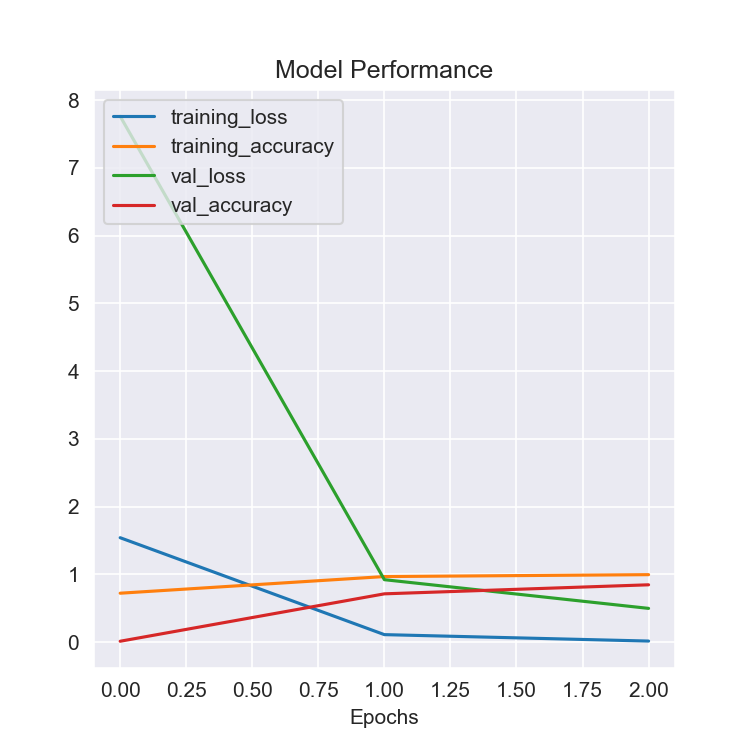

In [15]:
%matplotlib notebook
plt.figure(figsize=(5, 5))
sns.set_style("darkgrid")
plt.plot(training_performance.history['loss'],label='training_loss')
plt.plot(training_performance.history['accuracy'],label='training_accuracy')
plt.plot(training_performance.history['val_loss'],label='val_loss')
plt.plot(training_performance.history['val_accuracy'],label='val_accuracy')
plt.xlabel("Epochs")
plt.legend(loc='upper left')
plt.title('Model Performance')
plt.show()

**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

Test video path: v_PlayingCello_g04_c03.avi
1/1 [==============================] - 0s 35ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%



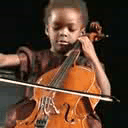

In [19]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])